### Desenvolvendo o Modelo de Série Temporal

O objetivo aqui é analisar a nossa série temporal para podermos ajustar um LSTM, e como o modelo é de deep learning, quanto mais dado melhor para nós.

In [1]:
# Libs:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Carregando os dados que baixamos pelo yfinance:
dataset = pd.read_csv(r"C:\Users\lucaa\Desktop\TechChallenge - Fase4\data\raw\dataset_PETR_st.csv")
dataset.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,Acao
0,2018-01-02,5.312316,16.549999,16.549999,16.190001,16.190001,33461800,PETR4
1,2018-01-03,5.360464,16.700001,16.719999,16.370001,16.490000,55940900,PETR4


In [3]:
# Describe da nossa dataset:
dataset.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1.656000e+03
mean,14.627233,27.563744,27.969674,27.156824,27.566727,6.591767e+07
std,9.404082,5.996867,6.001735,5.970058,5.974129,3.587860e+07
min,3.906060,11.290000,12.180000,10.850000,11.070000,0.000000e+00
25%,8.185170,23.495000,23.922500,23.127500,23.500000,4.292908e+07
50%,10.089991,27.180000,27.585000,26.820000,27.224999,5.785545e+07
75%,17.990360,30.832500,31.232500,30.342500,30.879999,7.933302e+07
max,39.599998,42.900002,42.939999,42.560001,42.770000,4.902304e+08


C:\Users\lucaa\AppData\Local\Temp\ipykernel_5332\3118577618.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datas_mensais = pd.to_datetime(pd.date_range(start = dataset["Date"].min(), end = dataset["Date"].max(), freq = 'Y'))


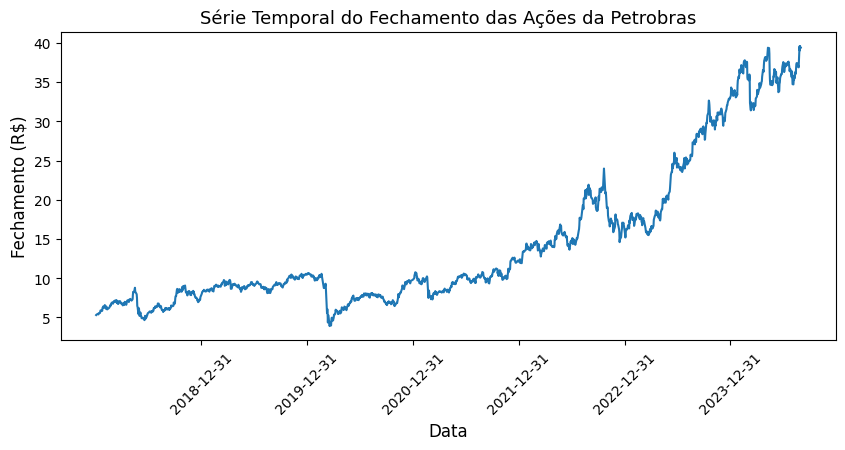

In [28]:
# Vamos plotar nossa série:

# Selecionando datas especificas para plotar:
datas_mensais = pd.to_datetime(pd.date_range(start = dataset["Date"].min(), end = dataset["Date"].max(), freq = 'Y'))

# Plotando a série temporal
plt.figure(figsize=(10, 4))
sns.lineplot(x = 'Date', y='Adj Close', data = dataset.assign(Date = lambda df_: pd.to_datetime(df_.Date)))
plt.xticks(datas_mensais, rotation = 45)
plt.title('Série Temporal do Fechamento das Ações da Petrobras', fontsize = 13)
plt.xlabel('Data', fontsize = 12)
plt.ylabel('Fechamento (R$)', fontsize = 12)
plt.show()

Comentando a série acima, podemos ver que não necessariamente podemos usar só uma parte para modelagem e predição, visto que o comportamento é linear ao longo do tempo, isto é, se usassemos somente os dados de 2022 pra trás, teriamos péssimas predições para dias atuais, onde o preço médio da ação aumentou significativamente. Dessa forma, importante utilizarmos um treinamento de até dias atuais, separando os últimos 60 dias, por exemplo, para validação do nosso modelo.

### Modelando a ST com LSTM

In [5]:
# Libs para modelagem:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
# Serie do Fechamento:
st_close = dataset['Adj Close'].values.reshape(-1, 1)
st_close

array([[ 5.31231594],
       [ 5.3604641 ],
       [ 5.37009287],
       ...,
       [39.59999847],
       [39.33000183],
       [39.36999893]])

In [ ]:
# Normalizando a Serie - usando o MinMax (convergencia facilitada):
scaler = MinMaxScaler()
st_close_scaled = scaler.fit_transform(st_close)
st_close_scaled

array([[0.03939763],
       [0.04074654],
       [0.0410163 ],
       ...,
       [1.        ],
       [0.99243578],
       [0.99355634]])

In [8]:
# Função para criar sequências de datas:
def sequencia(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [9]:
# Parâmetros de treinamento do LSTM:
seq_length = 10
split_ratio = 0.7

In [10]:
# Criar sequências
X, y = sequencia(st_close_scaled, seq_length)

In [11]:
# Dividindo os splits para treinametno e teste:
train_size = int(len(X) * split_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
# Modelo LSTM:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

c:\Users\lucaa\Desktop\TechChallenge - Fase4\env_name\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Treinando:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0096 - val_loss: 0.0318
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3149e-04 - val_loss: 0.0014
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9665e-04 - val_loss: 0.0033
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9760e-04 - val_loss: 0.0016
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5969e-04 - val_loss: 0.0024
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3437e-04 - val_loss: 0.0019
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2222e-04 - val_loss: 0.0024
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8012e-04 - val_loss: 0.0015
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8273e-04 - val_loss: 0.0015
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7277e-04 - val_loss: 0.0017
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━

In [17]:
# Fazer previsões
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [18]:
# Reverter normalização
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

In [19]:
# Calcular métricas
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

In [20]:
print(f'\nMétricas de Avaliação:')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


Métricas de Avaliação:
MAE: 0.98
RMSE: 1.21
MAPE: 4.01%


Ótimas métricas para um modelo que nem é tunado de serta forma, então acredito que nem seria necessário um tuning, mas como a ideia é implementar a técnica em si, vamos tentar otimizar alguns paramétros para termos uma melhora na performance e também evitar um overfitting.

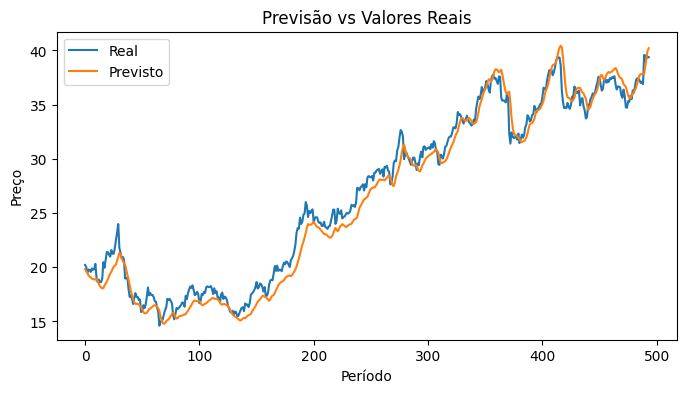

In [26]:
# Plotando o modelo ajustado:
plt.figure(figsize=(8, 4))
plt.plot(y_test_orig, label='Real')
plt.plot(y_pred_orig, label='Previsto')
plt.title('Previsão vs Valores Reais')
plt.xlabel('Período')
plt.ylabel('Preço')
plt.legend()
plt.show()

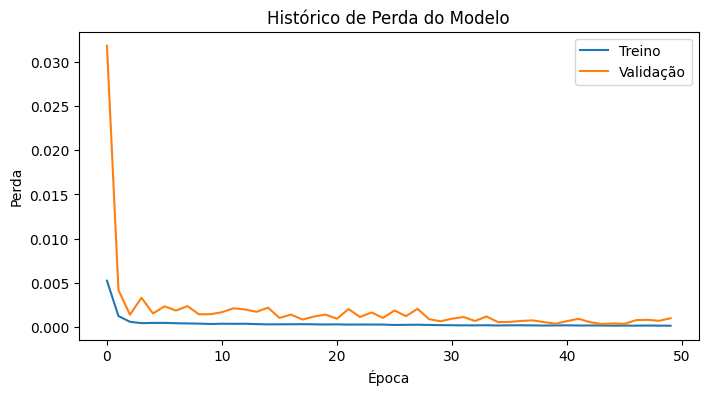

In [27]:
# Plotando o histórico dessa perda:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Histórico de Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

### Otimização de Hiperparâmetros

In [29]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Utilizando um otimizador:
optimizer = Adam(
    learning_rate = 0.001 # somente o learning rate, porque a previsao já esta boa, nos preocupa mais o overfitting
)
model.compile(optimizer=optimizer, loss='mse')

In [31]:
# Treinando - Tuning:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.2187e-04 - val_loss: 7.5391e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9262e-04 - val_loss: 4.5953e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6507e-04 - val_loss: 5.4132e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7535e-04 - val_loss: 3.9434e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6466e-04 - val_loss: 2.8286e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6795e-04 - val_loss: 4.5042e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5653e-04 - val_loss: 3.6212e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4491e-04 - val_loss: 7.7060e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9283e-04 - val_loss: 4.1117e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6153e-04 - val_loss: 5.2492e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8264e-04 - val_lo

In [32]:
# Avaliação
y_pred = model.predict(X_test)

# Reverter normalização
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# Métricas
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

print(f'\nMétricas de Avaliação:')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Métricas de Avaliação:
MAE: 0.65
RMSE: 0.84
MAPE: 2.51%


### Exportando o Modelo

In [53]:
import joblib
import json
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, save_model
import os

In [56]:
# Salvar o modelo em diferentes formatos
def save_lstm_model(model, scaler, sequence_length, model_dir):
    # 1. Salvar o modelo no formato H5
    model_path = os.path.join(model_dir, 'modelo_lstm.h5')
    save_model(model, model_path)
    
    # 2. Salvar a arquitetura do modelo em JSON
    model_json = model.to_json()
    json_path = os.path.join(model_dir, 'modelo_arquitetura.json')
    with open(json_path, 'w') as json_file:
        json_file.write(model_json)
    
    # 3. Salvar os pesos separadamente
    weights_path = os.path.join(model_dir, 'modelo.weights.h5')
    model.save_weights(weights_path)
    
    # 4. Salvar o scaler
    scaler_path = os.path.join(model_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    
    # 5. Salvar parâmetros importantes
    params = {
        'sequence_length': sequence_length,
        'input_shape': model.input_shape[1:],
        'output_shape': model.output_shape[1:],
        'model_version': '1.0'
    }
    
    params_path = os.path.join(model_dir, 'parametros.json')
    with open(params_path, 'w') as f:
        json.dump(params, f)

In [57]:
save_lstm_model(model, scaler, seq_length, "C:\\Users\\lucaa\\Desktop\\TechChallenge - Fase4\\models")